<a href="https://colab.research.google.com/github/GaurangSeth/GaurangSethMScDataScience/blob/master/03_git_DT%20and%20RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DT and RF


In [1]:
#conda install ipykernel

In [2]:
#conda install graphviz

## 1.0 Importing Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, xticks
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV,cross_validate,KFold
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,precision_score, recall_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn import preprocessing, utils

import xgboost as xgb
import lightgbm as lgbm

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.display import Image
from six import StringIO
from io import StringIO
import pydotplus
import graphviz


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 2.0 Defining functions to capture different Plots.
To be used throughout the code to capture plots at different stages

In [4]:
## Defining a function to plot the error analysis (Distribution-Plot)
def calculate_prediction_error(X_train,y_train,model):
    
    # Predict the target variable using the trained model
    #df_y_train_pred = pd.DataFrame({'Predicted': y_train_pred})
    y_train_pred = model.predict(X_train)

     # Create a DataFrame for predicted values
    y_train_pred = pd.DataFrame({'Predicted': y_train_pred})
    
    # Reset the index of y_train and drop the current index
    y_train_act = y_train.reset_index(drop=True)
    #y_train_act=y_train.copy()
    
    # Concatenate actual and predicted values
    y_train_error = pd.concat([y_train_act, y_train_pred], axis=1, join="inner")
    
    # Calculate the error
    y_train_error['Error'] = y_train_error['Plant C5PlusYield'] - y_train_error['Predicted']
    
    # Calculate the R2 score
    r2_score_value = r2_score(y_train, y_train_pred)
    
    # Plot the distribution of error terms
    fig = plt.figure()
    sns.distplot(y_train_error['Error'], bins=20)
    fig.suptitle('Error Terms Distribution', fontsize=10)
    plt.xlabel('Error Value', fontsize=10)
    plt.grid(True)
    
    
    return y_train_error, r2_score_value

In [5]:
## Defining a function to plot the error analysis (Scatter-Plot)
def plots(y,X,model,title,xlabel,ylabel):
    
    y_train_pred_train = model.predict(X)
    
    #converting Y pred array to dataframe
    y_train_pred=pd.DataFrame(y_train_pred_train, columns=['Pred'])
    y_train_pred

    #converting Y test series to dataframe
    y_train_df=y.copy()
    y_train_df.columns=['Train']
    y_train_df=y_train_df.reset_index()
    y_train_df

    # merging dataframes
    y_merged_train=pd.concat([y_train_pred,y_train_df], axis=1)
    y_merged_train=y_merged_train.set_index('index')
    y_merged_train=y_merged_train.sort_index(axis = 0)
    y_merged_train.head()

    plt.figure(figsize=(16,8))
    y_merged_train['x1'] = y_merged_train.index
    plt.scatter(y_merged_train['x1'],y_merged_train['Train'], c='b', marker='^', label='Train')
    plt.scatter(y_merged_train['x1'],y_merged_train['Pred'], c='r', marker='*', label='Pred')
    plt.legend(loc='upper left')
    plt.show()
    
    fig = plt.figure()
    #plt.scatter(y_train, y_train_pred)
    plt.scatter(y_merged_train['Train'] , y_merged_train['Pred'])
    fig.suptitle(title, fontsize = 20)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.grid(True)
 

In [6]:
# Defining a function for Evaluation Matrix barplots
def bar_plot_evalmetrics(dfs,metrics):
    combined_eval_metrics = pd.concat(dfs, axis=0)
    combined_eval_metrics = combined_eval_metrics.reset_index(drop=True)

    # Set the 'Method' column as the index
    df_evalmet_plot = combined_eval_metrics.set_index('Method')

    # Define the evaluation metrics to loop over
    metrics = metrics

    # Create subplots for each metric
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 15))

    # Iterate over the metrics and create subplots
    for i, metric in enumerate(metrics):
        # Get the column names for the metric
        columns = [col for col in df_evalmet_plot.columns if metric in col]

        # Plot the metric for Train/Test
        df_evalmet_plot[columns].plot(kind='bar', ax=axes[i], rot=45,grid=False)
        axes[i].set_xlabel('Method')
        axes[i].set_ylabel(metric)
        axes[i].set_title(f'{metric} (Train/Test)')


        # Add value labels on top of each bar
        for container in axes[i].containers:
            axes[i].bar_label(container, label_type='center', color='black', rotation=90)
            

    # Adjust the layout
    plt.tight_layout()
    plt.show()
    return combined_eval_metrics    

## 3.0 Reading Synthetic data and Data Cleansing
Performing the same outlier removal as done for other methodologies

In [7]:
url_synthetic_data='https://raw.githubusercontent.com/GaurangSeth/GaurangSethMScDataScience/master/CTGAN%20Generated%20data.csv'
df=pd.read_csv(url_synthetic_data)
df=df.rename(columns=lambda x: x.strip())

In [8]:
# Check the head of the dataset
df.head()

Feed N Plus 2A content  Reactor WAIT  H2 to HC  Reactor 1 Inlet Temp  \
0                   45.46       1004.48      3.28                998.41   
1                   44.22       1004.54      3.17                999.00   
2                   44.22       1004.54      3.17                996.97   
3                   45.49       1002.61      3.46                998.34   
4                   45.46       1004.34      3.31                998.17   

   Reactor 2 Inlet Temp  Reactor 3 Inlet Temp  Reactor 4 Inlet Temp  \
0               1000.46               1006.41               1011.81   
1                999.57               1003.23               1012.77   
2                999.72               1004.46               1012.81   
3                997.32               1001.66               1011.66   
4                999.71               1004.88               1013.84   

   Reactor 1 Delta T  Reactor 2 Delta T  Reactor 3 Delta T  Reactor 4 Delta T  \
0             166.26             108.39              72.02              39.17   
1             166.37             105.33              68.00              38.45   
2             165.14             107.33              69.92              39.13   
3             172.18             106.72              70.46              40.10   
4             165.81             107.55              69.72              39.09   

   Reactor 1 Delta P  Reactor 2 Delta P  Reactor 3 Delta P  Reactor 4 Delta P  \
0               1.17               2.73               2.77               3.17   
1               1.17               2.80               2.78               3.22   
2               1.16               2.74               2.77               3.25   
3               1.25               2.72               2.76               3.18   
4               1.16               2.77               2.76               3.09   

   Seperator Pressure  Seperator Temperature  Recycle gas purity  \
0               30.83                 100.62               78.67   
1               30.32                 103.02               78.67   
2               30.27                 103.55               78.67   
3               32.56                 103.20               77.88   
4               30.39                 103.05               78.67   

   Net gas Hydrogen Purity  Coke on Spent Catalyst  Chloride Injection rate  \
0                    88.24                    3.82                     2.59   
1                    88.24                    3.56                     2.64   
2                    88.24                    3.56                     2.58   
3                    88.40                    3.82                     2.60   
4                    88.24                    3.82                     2.60   

   Total Paraffins in feed  Total Naphthenes in feed  Total Aromatics in feed  \
0                    64.91                     24.60                    10.43   
1                    65.89                     23.58                    10.32   
2                    65.89                     23.58                    10.32   
3                    63.35                     27.07                     9.21   
4                    64.91                     24.60                    10.43   

   Total olefins in Feed  Reactor LHSV  Feed IBP  50% IBP    WABT  \
0                   0.06          1.62    194.19   250.57  959.41   
1                   0.21          1.62    192.95   247.78  960.68   
2                   0.21          1.62    192.95   247.78  960.68   
3                   0.35          1.62    194.06   249.98  957.49   
4                   0.06          1.62    194.19   250.57  959.56   

   Plant C5PlusYield  
0              83.24  
1              83.20  
2              83.20  
3              83.46  
4              83.33

In [9]:
df.shape

(5962, 30)

In [10]:
df.describe()

Feed N Plus 2A content  Reactor WAIT     H2 to HC  \
count             5962.000000   5962.000000  5962.000000   
mean                47.972068    982.563648     3.814648   
std                  2.046191     14.284562     0.335320   
min                 40.380000    963.040000     3.100000   
25%                 47.000000    968.530000     3.560000   
50%                 48.150000    980.890000     3.770000   
75%                 49.380000    991.927500     4.030000   
max                 59.890000   1009.490000     5.660000   

       Reactor 1 Inlet Temp  Reactor 2 Inlet Temp  Reactor 3 Inlet Temp  \
count           5962.000000           5962.000000           5962.000000   
mean             975.295392            982.172801            983.606872   
std               13.532721             15.434145             13.933120   
min              945.740000            951.400000            960.060000   
25%              964.770000            966.470000            970.472500   
50%              970.845000            981.850000            981.610000   
75%              984.447500            994.270000            995.450000   
max             1004.350000           1015.790000           1009.320000   

       Reactor 4 Inlet Temp  Reactor 1 Delta T  Reactor 2 Delta T  \
count           5962.000000        5962.000000        5962.000000   
mean             986.789906         161.030943         106.133452   
std               15.674754           7.303361           6.186524   
min              964.350000         134.380000          86.240000   
25%              971.550000         156.232500         101.560000   
50%              986.385000         161.160000         106.120000   
75%              996.162500         166.407500         110.450000   
max             1015.620000         176.950000         128.670000   

       Reactor 3 Delta T  Reactor 4 Delta T  Reactor 1 Delta P  \
count        5962.000000        5962.000000        5962.000000   
mean           71.095792          41.762420           0.992466   
std             3.766175           4.140208           0.341575   
min            52.290000          22.690000           0.450000   
25%            69.530000          39.670000           0.650000   
50%            71.350000          42.580000           1.100000   
75%            73.137500          44.670000           1.310000   
max            83.260000          51.740000           1.880000   

       Reactor 2 Delta P  Reactor 3 Delta P  Reactor 4 Delta P  \
count        5962.000000        5962.000000        5962.000000   
mean            2.587736           2.640976           2.805659   
std             0.091843           0.132266           0.240884   
min             2.330000           2.150000           2.130000   
25%             2.520000           2.530000           2.640000   
50%             2.570000           2.650000           2.840000   
75%             2.670000           2.750000           2.980000   
max             2.820000           2.920000           3.280000   

       Seperator Pressure  Seperator Temperature  Recycle gas purity  \
count         5962.000000            5962.000000         5962.000000   
mean            33.360704             105.697828           81.232031   
std              1.310147               3.924914            9.579163   
min             28.650000              92.960000            0.860000   
25%             32.510000             103.290000           80.880000   
50%             33.490000             105.805000           82.550000   
75%             34.300000             108.307500           83.450000   
max             36.500000             119.300000           86.820000   

       Net gas Hydrogen Purity  Coke on Spent Catalyst  \
count              5962.000000             5962.000000   
mean                 89.338293                3.165453   
std                   1.220673                0.819124   
min                  86.110000                1.820000   
25%                  88.250000         

In [11]:
### Removing outliers using Q1-1.5IQR & Q3+1.5IQR
def mod_outlier(df):
    
        df1 = df.copy()
        df1 = df1._get_numeric_data()

        df2 = df.copy()

        q1 = df1.quantile(0.1)
        q3 = df1.quantile(0.9)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)


        for col in df.columns:
            for i in range(0,len(df1[col])):
                if df1[col][i] < lower_bound[col]:            
                    df1[col][i] = np.nan

                if df1[col][i] > upper_bound[col]:            
                    df1[col][i] = np.nan


            for col in df.columns:
                df2[col] = df1[col]

        return(df2)
    
    
df_outlier_removed = mod_outlier(df)
#print(df_outlier_removed.isna().sum())
df_outlier_removed=df_outlier_removed.dropna()
df_outlier_removed=df_outlier_removed.reset_index(drop=True)
df_outlier_removed.head()

Feed N Plus 2A content  Reactor WAIT  H2 to HC  Reactor 1 Inlet Temp  \
0                   45.46       1004.48      3.28                998.41   
1                   44.22       1004.54      3.17                999.00   
2                   44.22       1004.54      3.17                996.97   
3                   45.49       1002.61      3.46                998.34   
4                   45.46       1004.34      3.31                998.17   

   Reactor 2 Inlet Temp  Reactor 3 Inlet Temp  Reactor 4 Inlet Temp  \
0               1000.46               1006.41               1011.81   
1                999.57               1003.23               1012.77   
2                999.72               1004.46               1012.81   
3                997.32               1001.66               1011.66   
4                999.71               1004.88               1013.84   

   Reactor 1 Delta T  Reactor 2 Delta T  Reactor 3 Delta T  Reactor 4 Delta T  \
0             166.26             108.39              72.02              39.17   
1             166.37             105.33              68.00              38.45   
2             165.14             107.33              69.92              39.13   
3             172.18             106.72              70.46              40.10   
4             165.81             107.55              69.72              39.09   

   Reactor 1 Delta P  Reactor 2 Delta P  Reactor 3 Delta P  Reactor 4 Delta P  \
0               1.17               2.73               2.77               3.17   
1               1.17               2.80               2.78               3.22   
2               1.16               2.74               2.77               3.25   
3               1.25               2.72               2.76               3.18   
4               1.16               2.77               2.76               3.09   

   Seperator Pressure  Seperator Temperature  Recycle gas purity  \
0               30.83                 100.62               78.67   
1               30.32                 103.02               78.67   
2               30.27                 103.55               78.67   
3               32.56                 103.20               77.88   
4               30.39                 103.05               78.67   

   Net gas Hydrogen Purity  Coke on Spent Catalyst  Chloride Injection rate  \
0                    88.24                    3.82                     2.59   
1                    88.24                    3.56                     2.64   
2                    88.24                    3.56                     2.58   
3                    88.40                    3.82                     2.60   
4                    88.24                    3.82                     2.60   

   Total Paraffins in feed  Total Naphthenes in feed  Total Aromatics in feed  \
0                    64.91                     24.60                    10.43   
1                    65.89                     23.58                    10.32   
2                    65.89                     23.58                    10.32   
3                    63.35                     27.07                     9.21   
4                    64.91                     24.60                    10.43   

   Total olefins in Feed  Reactor LHSV  Feed IBP  50% IBP    WABT  \
0                   0.06          1.62    194.19   250.57  959.41   
1                   0.21          1.62    192.95   247.78  960.68   
2                   0.21          1.62    192.95   247.78  960.68   
3                   0.35          1.62    194.06   249.98  957.49   
4                   0.06          1.62    194.19   250.57  959.56   

   Plant C5PlusYield  
0              83.24  
1              83.20  
2              83.20  
3              83.46  
4              83.33

## 4.1 Using Decision Tree Regressor- Without HyperParameter Tuning

                  VarName  Importance
0  Feed N Plus 2A content    0.006645
1            Reactor WAIT    0.037384
2                H2 to HC    0.006626
3    Reactor 1 Inlet Temp    0.093981
4    Reactor 2 Inlet Temp    0.000000
5    Reactor 3 Inlet Temp    0.000000
6    Reactor 4 Inlet Temp    0.000000
7       Reactor 1 Delta T    0.000000
8       Reactor 2 Delta T    0.000000
9       Reactor 3 Delta T    0.029844


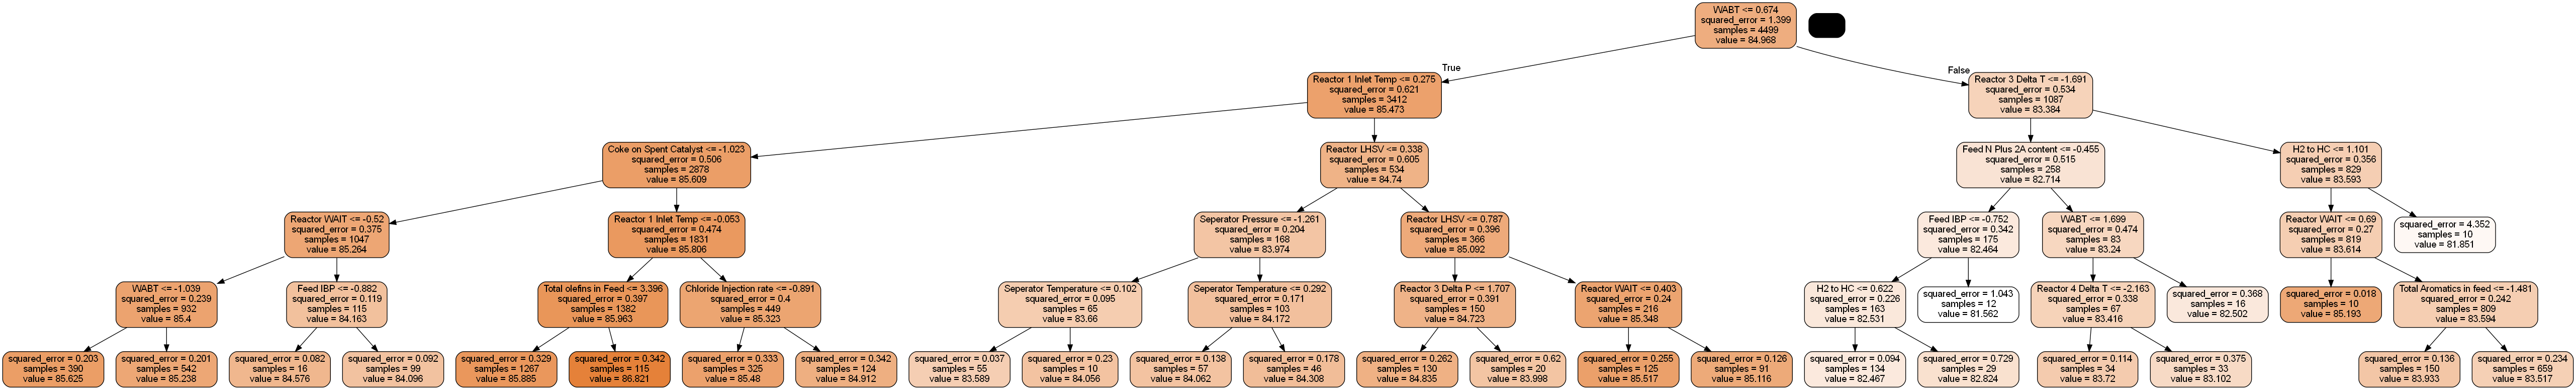

In [12]:
# Creating a data frame after removing the Target variable
X = df_outlier_removed.drop(['Plant C5PlusYield'], axis=1)
y = df_outlier_removed[['Plant C5PlusYield']]

# Scaling X variables
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(X), columns=X.columns)

# Performing a Train Test Split
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, random_state=104, test_size=0.2, shuffle=True)

# Initiating a decision tree
dt = DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_leaf=10)

# Fitting the tree
dt.fit(X_train_dt, y_train_dt)

# Visualising the Tree
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, feature_names=X_train_dt.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Using the model on Train data to identify r-squared
y_train_pred_dt = dt.predict(X_train_dt)
#r2_score_train_dt = r2_score(y_train_dt, y_train_pred_dt)


# Using the model on Test data to identify r-squared
y_test_pred_dt = dt.predict(X_test_dt)
#r2_score_test_dt = r2_score(y_test_dt, y_test_pred_dt)

r2_score_train_dt = r2_score(y_train_dt, y_train_pred_dt)
r2_score_test_dt = r2_score(y_test_dt, y_test_pred_dt)
mae_train_dt = mean_absolute_error(y_train_dt, y_train_pred_dt)
mae_test_dt = mean_absolute_error(y_test_dt, y_test_pred_dt)
rmse_train_dt = np.sqrt(mean_squared_error(y_train_dt, y_train_pred_dt))
rmse_test_dt = np.sqrt(mean_squared_error(y_test_dt, y_test_pred_dt))    

#Evaluation Metrics
evaluation_metrics_dt = pd.DataFrame({'Method':'Decision Tree','R2 Score (Train)': [r2_score_train_dt], 'R2 Score (Test)':[r2_score_test_dt],
                                       'MAE (Train)': [mae_train_dt], 'MAE (Test)':[mae_test_dt],
                                       'RMSE (Train)': [rmse_train_dt], 'RMSE (Test)':[rmse_test_dt]})

# print(f'R Squared Score for Train Data: {r2_score_train_dt}')
# print(f'R Squared Score for Test Data: {r2_score_test_dt}')

## Feature Importance of variables
imp_df_dt = pd.DataFrame({"VarName": X_train_dt.columns,"Importance": dt.feature_importances_})
imp_df_dt.sort_values(by="Importance", ascending=False)
print(imp_df_dt.reset_index(drop=True).head(10))

# Display the decision tree as an image
Image(graph.create_png())

In [13]:
evaluation_metrics_dt

Method  R2 Score (Train)  R2 Score (Test)  MAE (Train)  MAE (Test)  \
0  Decision Tree          0.809024         0.792464     0.363566     0.38761   

   RMSE (Train)  RMSE (Test)  
0      0.516955     0.534752

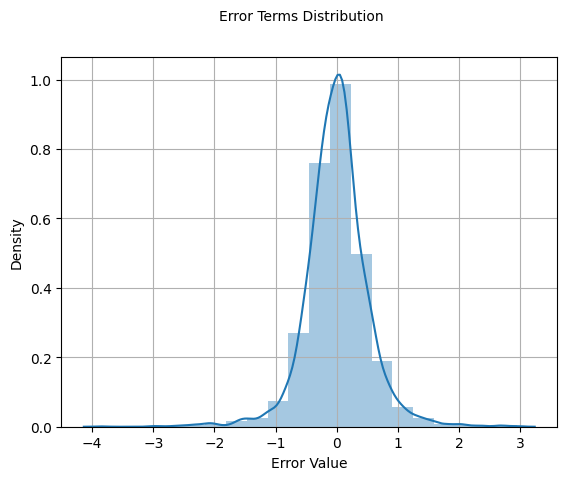

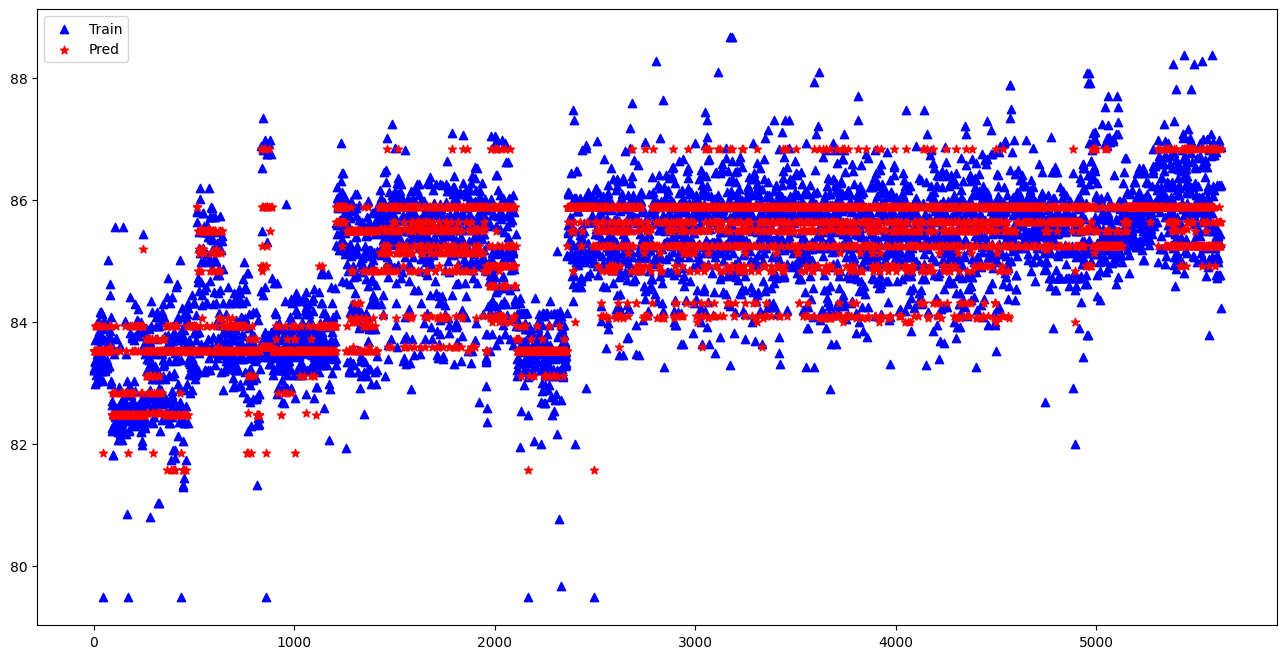

R2 Score: 0.8090235853077078


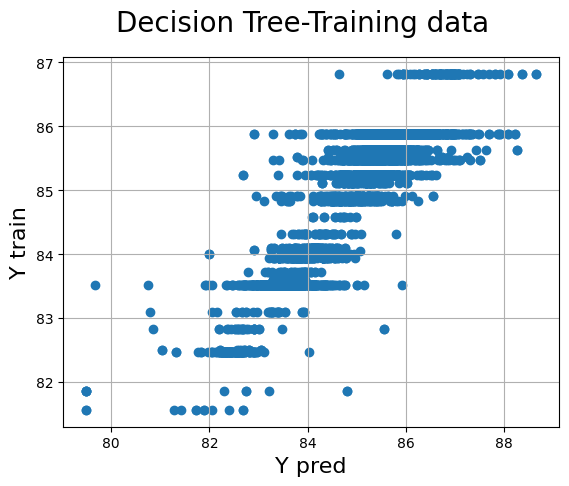

In [14]:
## Checking performance of DT on Train Data
y_merged_train_dt, r2_train_dt=calculate_prediction_error(X_train_dt,y_train_dt,dt)
plots(y_train_dt, X_train_dt, dt,"Decision Tree-Training data",'Y pred','Y train')
print("R2 Score:", r2_train_dt)

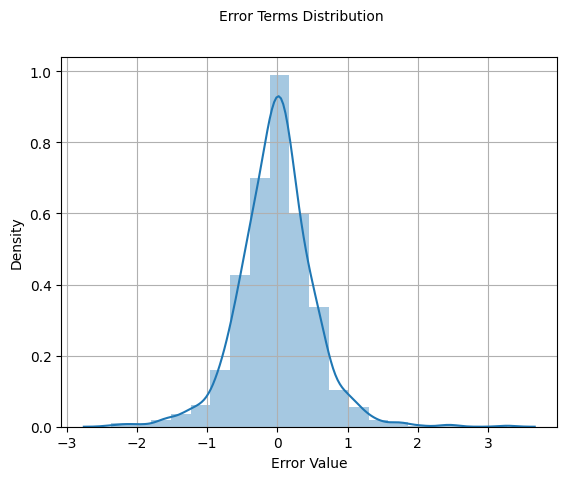

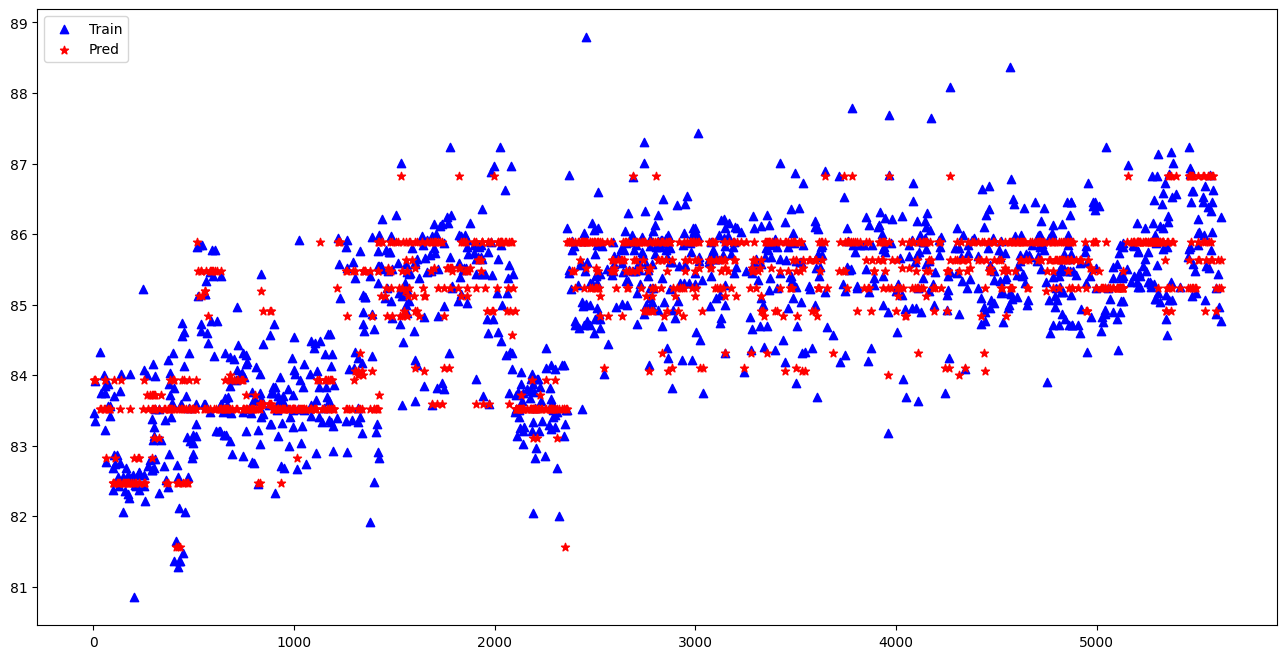

R2 Score: 0.7924644986633498


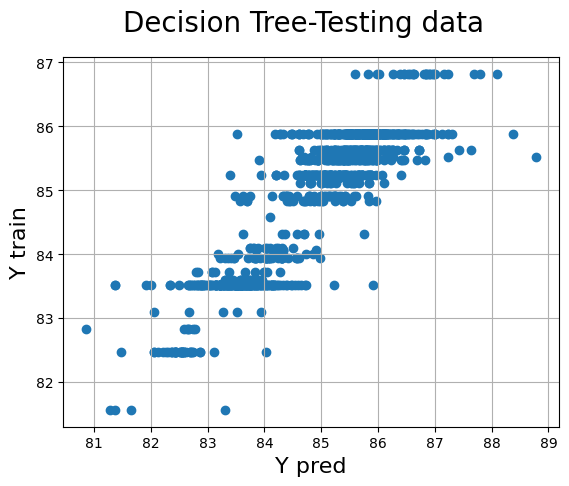

In [15]:
## Checking performance of DT on Test Data
y_merged_test_dt, r2_test_dt=calculate_prediction_error(X_test_dt,y_test_dt,dt)
plots(y_test_dt, X_test_dt, dt,"Decision Tree-Testing data",'Y pred','Y train')
print("R2 Score:", r2_test_dt)

## 4.2 Using Random Forest Regressor- Without HyperParameter Tuning

In [16]:
# Performing a Train Test Split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, random_state=104, test_size=0.2, shuffle=True)

# Initiating a random forest regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=5, min_samples_leaf=10)

# Fitting the tree
rf.fit(X_train_rf, y_train_rf)

# Using the model on Train data to identify r-squared
y_train_pred_rf = rf.predict(X_train_rf)
#r2_score_train_rf = r2_score(y_train_rf, y_train_pred_rf)

# Using the model on Test data to identify r-squared
y_test_pred_rf = rf.predict(X_test_rf)
#r2_score_test_rf = r2_score(y_test_rf, y_test_pred_rf)

r2_score_train_rf = r2_score(y_train_rf, y_train_pred_rf)
r2_score_test_rf = r2_score(y_test_rf, y_test_pred_rf)
mae_train_rf = mean_absolute_error(y_train_rf, y_train_pred_rf)
mae_test_rf = mean_absolute_error(y_test_rf, y_test_pred_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train_rf, y_train_pred_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test_rf, y_test_pred_rf))    

#Evaluation Metrics
evaluation_metrics_rf = pd.DataFrame({'Method':'Random Forest','R2 Score (Train)': [r2_score_train_rf], 'R2 Score (Test)':[r2_score_test_rf],
                                       'MAE (Train)': [mae_train_rf], 'MAE (Test)':[mae_test_rf],
                                       'RMSE (Train)': [rmse_train_rf], 'RMSE (Test)':[rmse_test_rf]})


# print(f'R Squared Score for Train Data: {r2_score_train_rf}')
# print(f'R Squared Score for Test Data: {r2_score_test_rf}')

## Feature Importance of variables
imp_df = pd.DataFrame({"VarName": X_train_rf.columns,"Importance": rf.feature_importances_})
imp_df.sort_values(by="Importance", ascending=False)
imp_df.reset_index(drop=True).head(10)

VarName  Importance
0  Feed N Plus 2A content    0.004367
1            Reactor WAIT    0.027039
2                H2 to HC    0.007473
3    Reactor 1 Inlet Temp    0.068796
4    Reactor 2 Inlet Temp    0.000561
5    Reactor 3 Inlet Temp    0.003219
6    Reactor 4 Inlet Temp    0.001523
7       Reactor 1 Delta T    0.002333
8       Reactor 2 Delta T    0.000144
9       Reactor 3 Delta T    0.029315

In [17]:
evaluation_metrics_rf

Method  R2 Score (Train)  R2 Score (Test)  MAE (Train)  MAE (Test)  \
0  Random Forest          0.839233         0.828499     0.329889    0.351163   

   RMSE (Train)  RMSE (Test)  
0      0.474309     0.486115

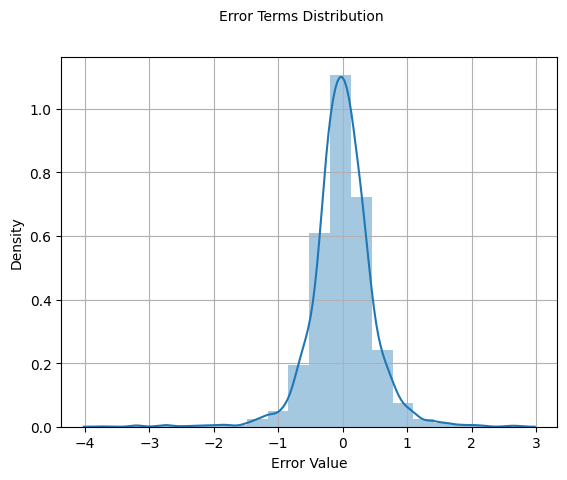

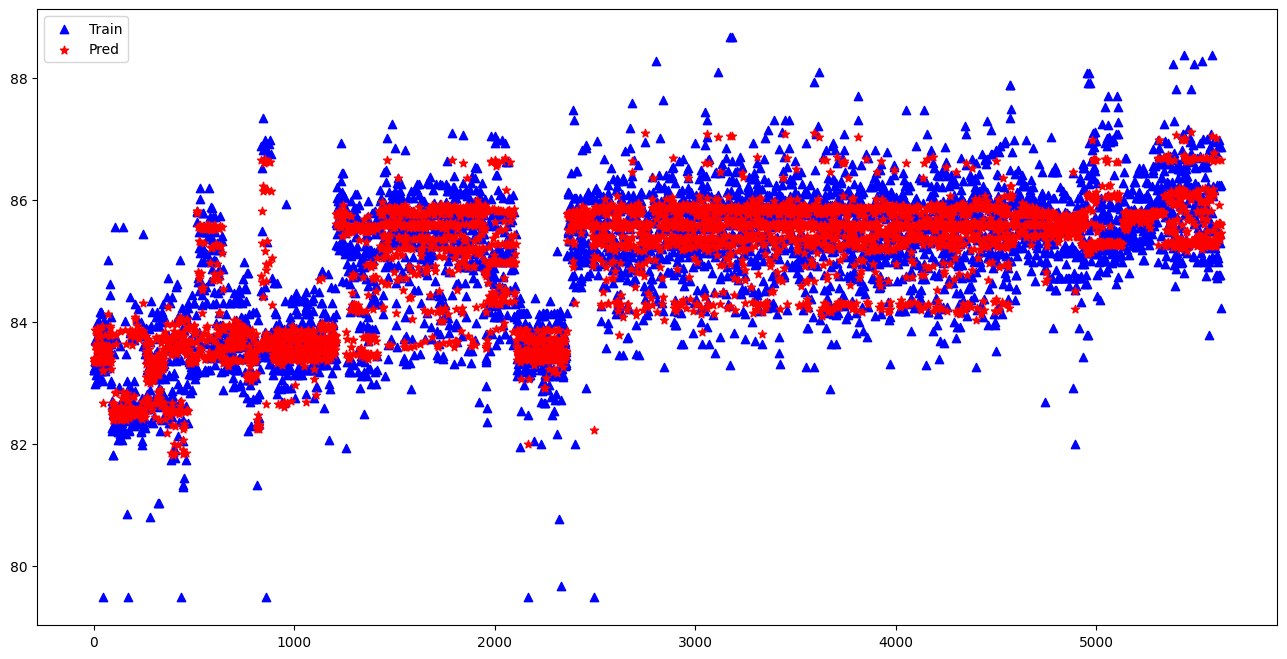

R2 Score: 0.8392331255470594


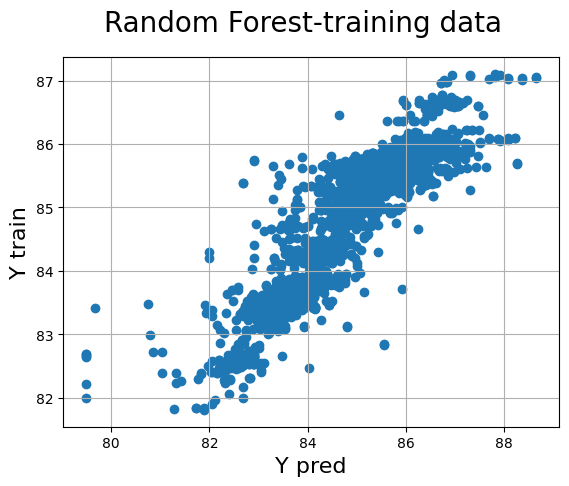

In [18]:
## Checking performance of RF on Train Data
y_merged_train_rf, r2_train_rf=calculate_prediction_error(X_train_rf,y_train_rf,rf)
plots(y_train_rf, X_train_rf, rf,"Random Forest-training data",'Y pred','Y train')
print("R2 Score:", r2_train_rf)

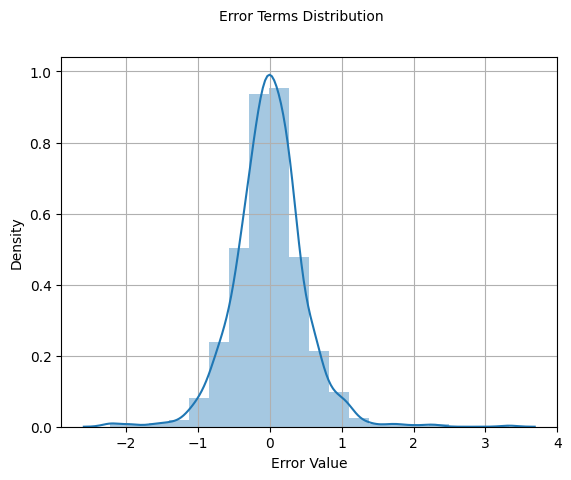

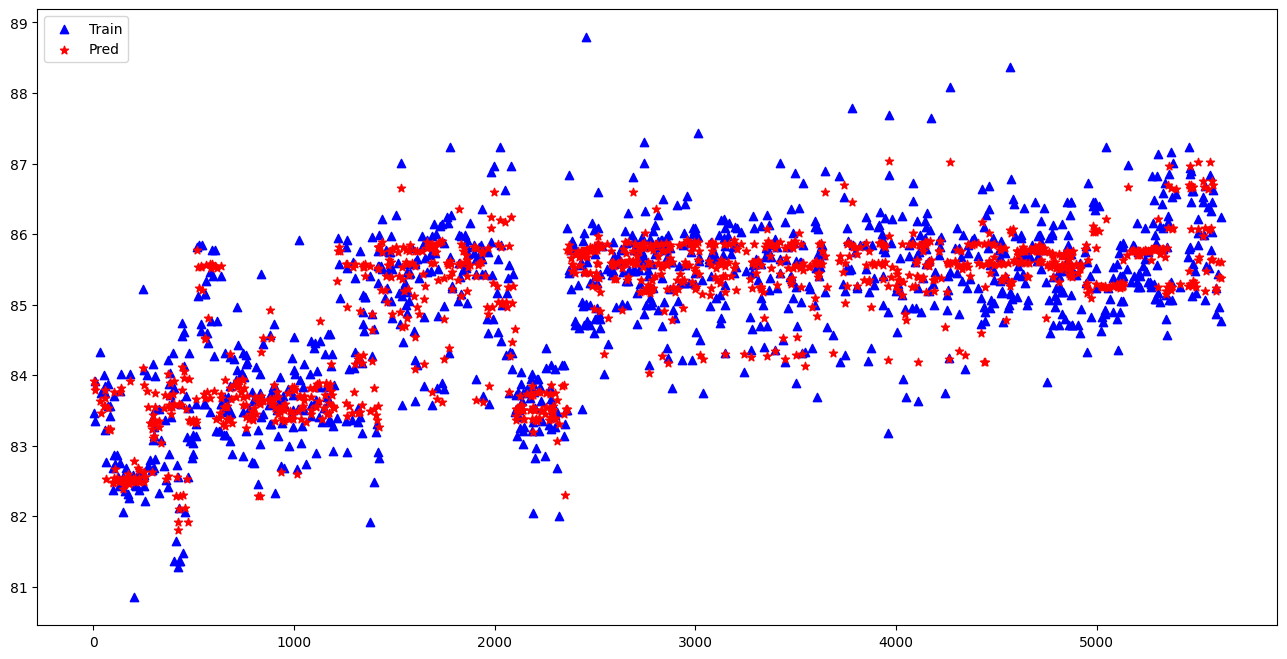

R2 Score: 0.8284994069551235


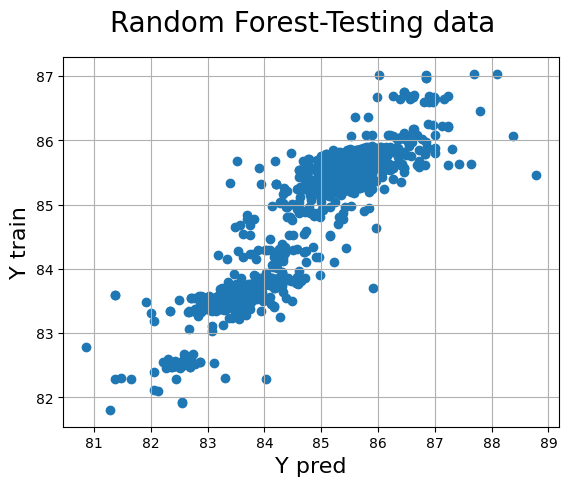

In [19]:
## Checking performance of RF on Test Data
y_merged_test_rf, r2_test_rf=calculate_prediction_error(X_test_rf,y_test_rf,rf)
plots(y_test_rf, X_test_rf, rf,"Random Forest-Testing data",'Y pred','Y train')
print("R2 Score:", r2_test_rf)

## 5.1 Using Decision Tree Regressor- With HyperParameter Tuning

In [20]:
%%time

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameters to tune
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100, 500],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Create the Decision Tree regressor
dt = DecisionTreeRegressor(random_state=42)

# Perform grid search with cross-validation on train data
grid_search_train = GridSearchCV(estimator=dt, param_grid=params, cv=10, scoring='r2',verbose=0)
grid_search_train.fit(X_train_dt, y_train_dt)

# Get the best estimator and its corresponding hyperparameters
dt_best_train = grid_search_train.best_estimator_
best_params_train = grid_search_train.best_params_

print("Best Hyperparameters (Train Data): ", best_params_train)

# Perform grid search with cross-validation on the whole dataset
grid_search_full = GridSearchCV(estimator=dt, param_grid=params, cv=10, scoring='r2',verbose=0)
grid_search_full.fit(X, y)

# Get the best estimator and its corresponding hyperparameters
dt_best_full = grid_search_full.best_estimator_
best_params_full = grid_search_full.best_params_

print("Best Hyperparameters (Full Data): ", best_params_full)

# Predict on train and test data using the best models
y_train_pred_train_dt = dt_best_train.predict(X_train_dt)
y_test_pred_train_dt = dt_best_train.predict(X_test_dt)
train_r2_train_dt = r2_score(y_train_dt, y_train_pred_train_dt)
test_r2_train_dt = r2_score(y_test_dt, y_test_pred_train_dt)
train_mae_train_dt = mean_absolute_error(y_train_dt, y_train_pred_train_dt)
test_mae_train_dt = mean_absolute_error(y_test_dt, y_test_pred_train_dt)
train_rmse_train_dt = np.sqrt(mean_squared_error(y_train_dt, y_train_pred_train_dt))
test_rmse_train_dt = np.sqrt(mean_squared_error(y_test_dt, y_test_pred_train_dt))

evaluation_metrics_dtBestModel_traindata = pd.DataFrame({'Method':'Decision Tree Grid search-Train Data',
                                        'R2 Score (Train)': [train_r2_train_dt], 'R2 Score (Test)':[test_r2_train_dt],
                                       'MAE (Train)': [train_mae_train_dt], 'MAE (Test)':[test_mae_train_dt],
                                       'RMSE (Train)': [train_rmse_train_dt], 'RMSE (Test)':[test_rmse_train_dt]})

y_train_pred_full = dt_best_full.predict(X_train_dt)
y_test_pred_full = dt_best_full.predict(X_test_dt)
train_r2_full_dt = r2_score(y_train_dt, y_train_pred_full)
test_r2_full_dt = r2_score(y_test_dt, y_test_pred_full)
train_mae_full_dt = mean_absolute_error(y_train_dt, y_train_pred_full)
test_mae_full_dt = mean_absolute_error(y_test_dt, y_test_pred_full)
train_rmse_full_dt = np.sqrt(mean_squared_error(y_train_dt, y_train_pred_full))
test_rmse_full_dt = np.sqrt(mean_squared_error(y_test_dt, y_test_pred_full))
evaluation_metrics_dtBestModel_fulldata = pd.DataFrame({'Method':'Decision Tree Grid search-Complete Data',
                                        'R2 Score (Train)': [train_r2_full_dt], 'R2 Score (Test)':[test_r2_full_dt],
                                       'MAE (Train)': [train_mae_full_dt], 'MAE (Test)':[test_mae_full_dt],
                                       'RMSE (Train)': [train_rmse_full_dt], 'RMSE (Test)':[test_rmse_full_dt]})


## Feature Importance of variables
imp_df_dt_train = pd.DataFrame({"VarName": X_train_dt.columns, "Importance": dt_best_train.feature_importances_})
imp_df_dt_train.sort_values(by="Importance", ascending=False, inplace=True)
print("Top 10 Variable Importance (Train Data - Hyperparameter Tuning on Train Data):")
print(imp_df_dt_train.head(10))

imp_df_dt_full = pd.DataFrame({"VarName": X_train_dt.columns, "Importance": dt_best_full.feature_importances_})
imp_df_dt_full.sort_values(by="Importance", ascending=False, inplace=True)
print("Top 10 Variable Importance (Train Data - Hyperparameter Tuning on Full Data):")
print(imp_df_dt_full.head(10))

Best Hyperparameters (Train Data):  {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best Hyperparameters (Full Data):  {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Top 10 Variable Importance (Train Data - Hyperparameter Tuning on Train Data):
                   VarName  Importance
28                    WABT    0.632764
3     Reactor 1 Inlet Temp    0.085218
1             Reactor WAIT    0.045944
25            Reactor LHSV    0.043687
19  Coke on Spent Catalyst    0.035730
9        Reactor 3 Delta T    0.029894
2                 H2 to HC    0.024567
24   Total olefins in Feed    0.017796
0   Feed N Plus 2A content    0.009247
13       Reactor 3 Delta P    0.008365
Top 10 Variable Importance (Train Data - Hyperparameter Tuning on Full Data):
                    VarName  Importance
28                     WABT    0.663821
3      Reactor 1 Inlet Temp    0.054731
25             Reactor LHSV    0.042691
20  Chl

In [21]:
evaluation_metrics_dtBestModel=pd.concat([evaluation_metrics_dtBestModel_traindata,evaluation_metrics_dtBestModel_fulldata],
                                         axis=0)
evaluation_metrics_dtBestModel

Method  R2 Score (Train)  R2 Score (Test)  \
0     Decision Tree Grid search-Train Data          0.925010         0.867314   
0  Decision Tree Grid search-Complete Data          0.930322         0.932595   

   MAE (Train)  MAE (Test)  RMSE (Train)  RMSE (Test)  
0     0.208355    0.285682      0.323941     0.427581  
0     0.197309    0.197696      0.312257     0.304756

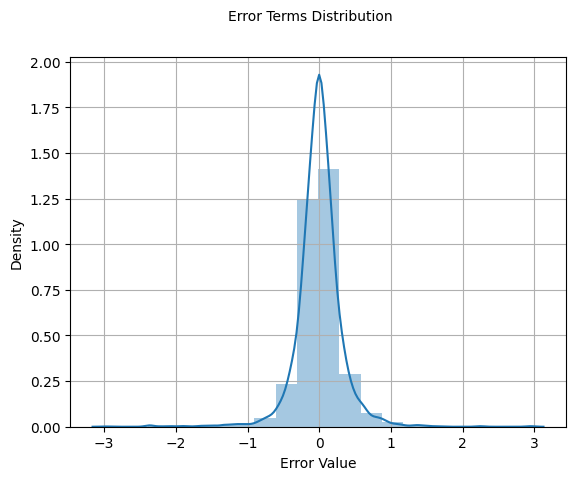

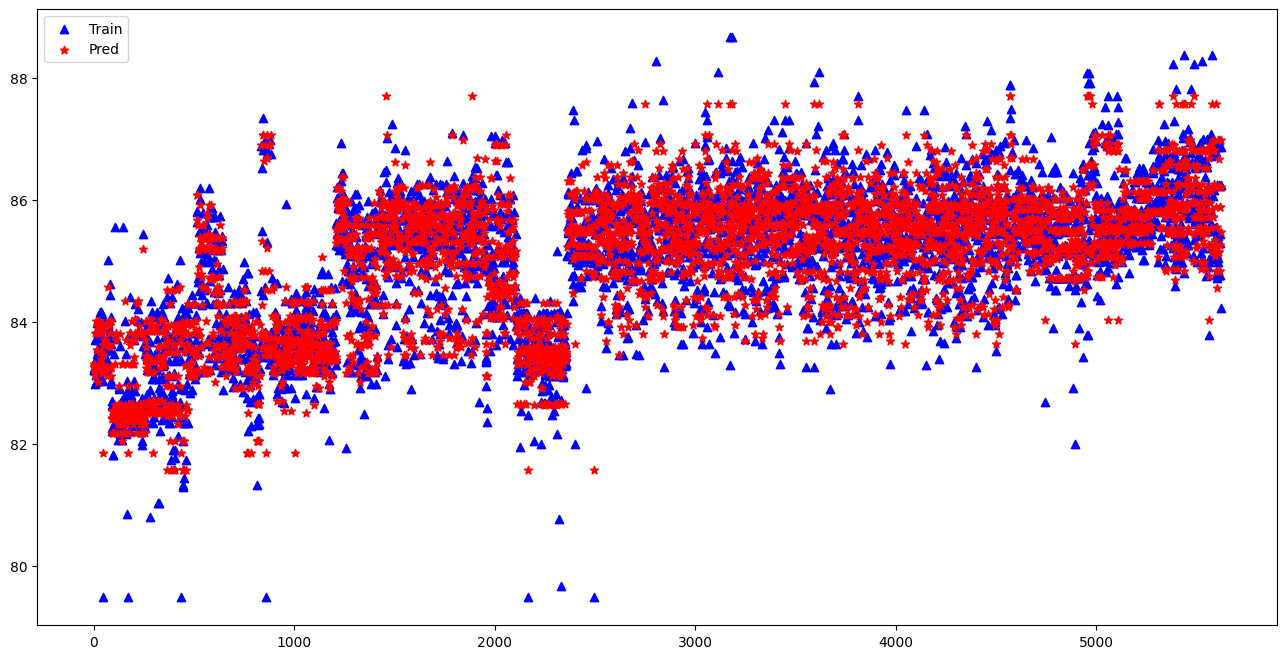

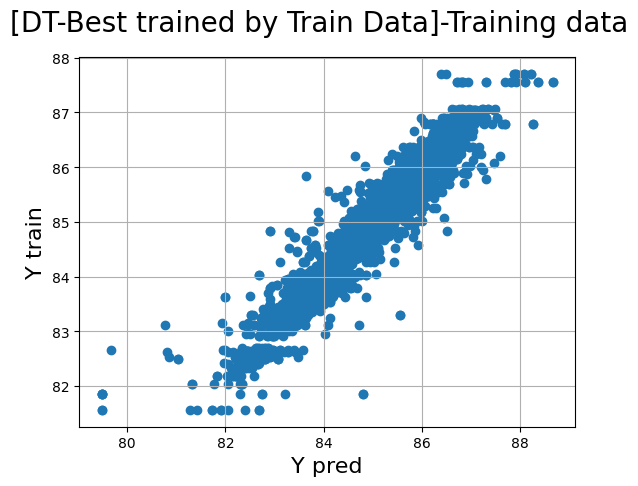

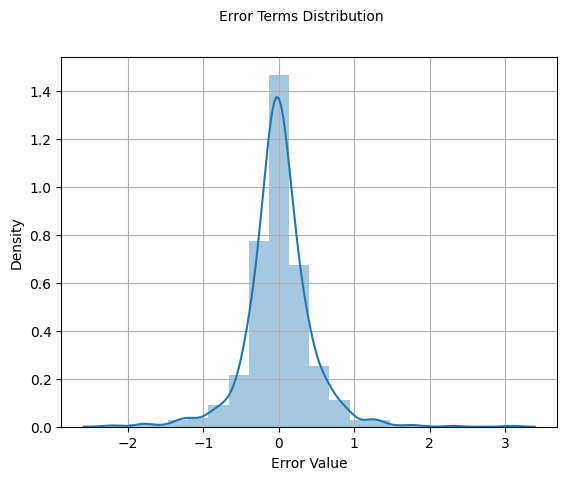

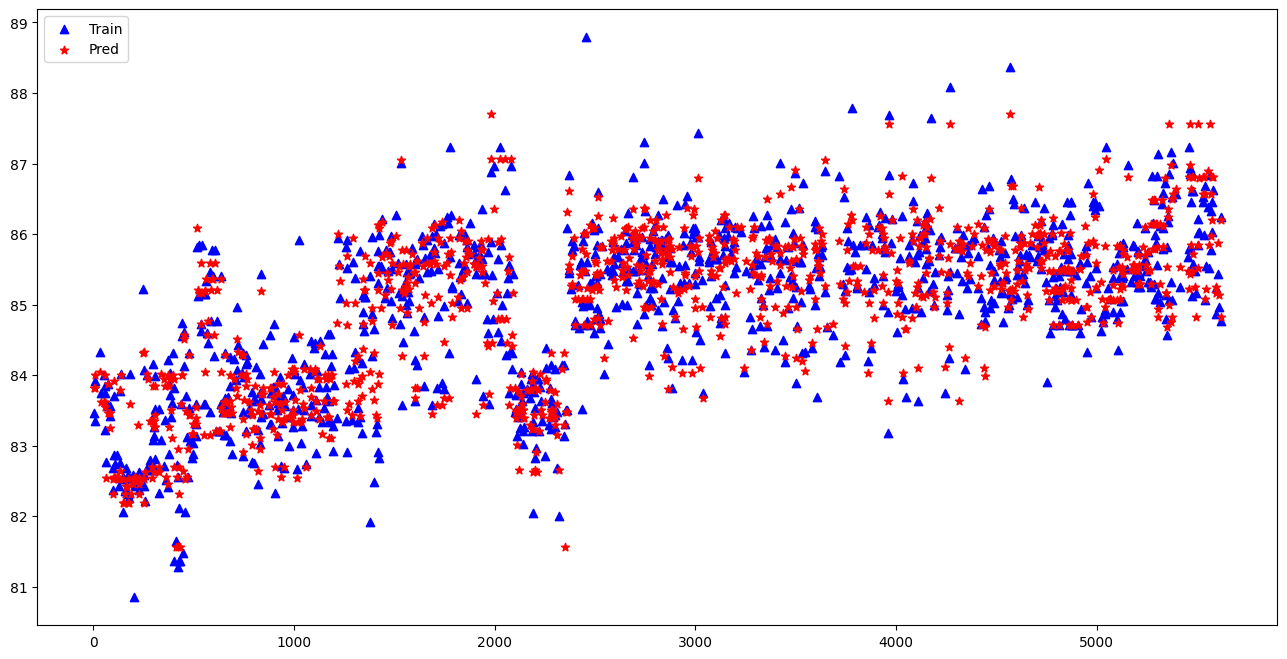

R2 Score Train: 0.9250097398682284
R2 Score Test: 0.8673144604492405


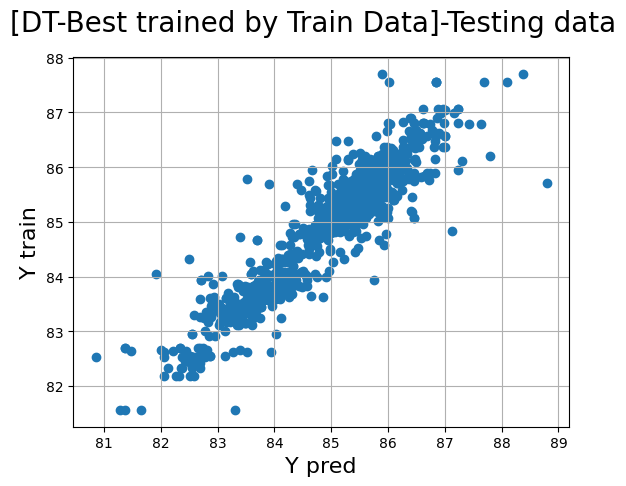

In [22]:
## Checking performance of [DT-Best trained by Train Data] on Train Data
y_merged_train_dt, r2_train_dt_best_train=calculate_prediction_error(X_train_dt,y_train_dt,dt_best_train)
plots(y_train_dt, X_train_dt, dt_best_train,"[DT-Best trained by Train Data]-Training data",'Y pred','Y train')

## Checking performance of [DT-Best trained by Train Data] on Test Data
y_merged_test_dt, r2_test_dt_best_train=calculate_prediction_error(X_test_dt,y_test_dt,dt_best_train)
plots(y_test_dt, X_test_dt, dt_best_train,"[DT-Best trained by Train Data]-Testing data",'Y pred','Y train')

print("R2 Score Train:", r2_train_dt_best_train)
print("R2 Score Test:", r2_test_dt_best_train)

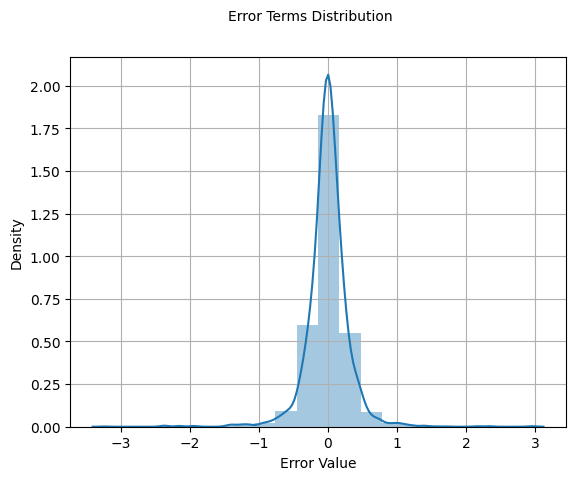

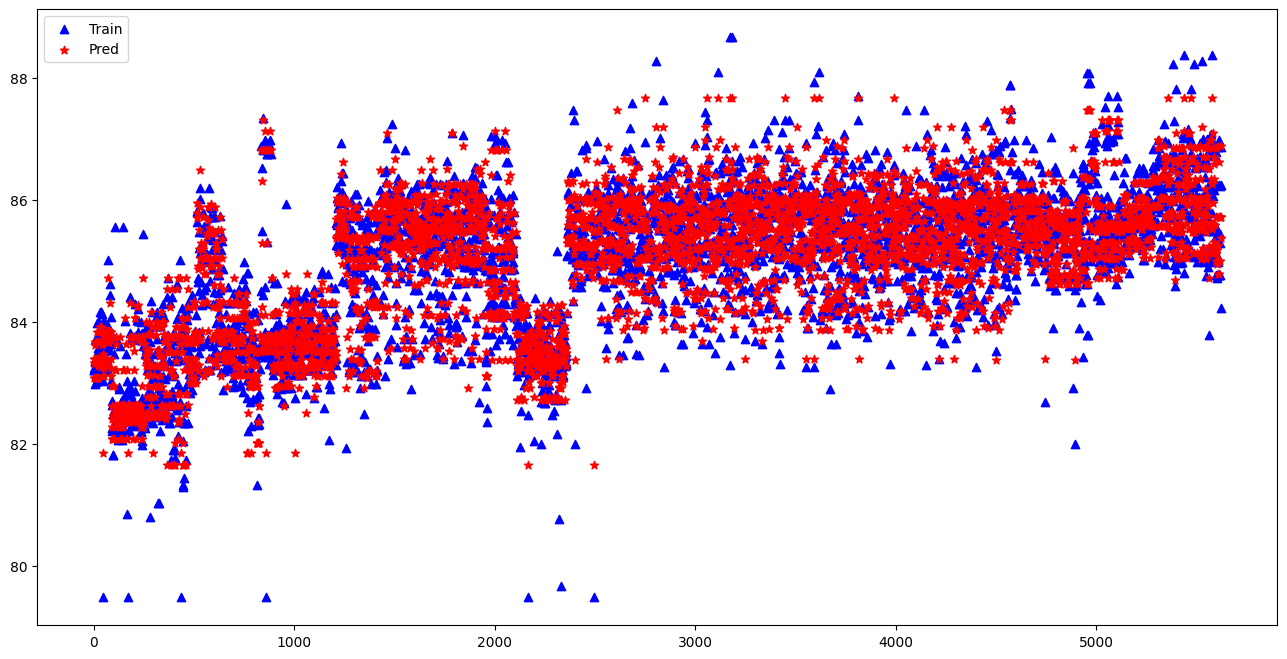

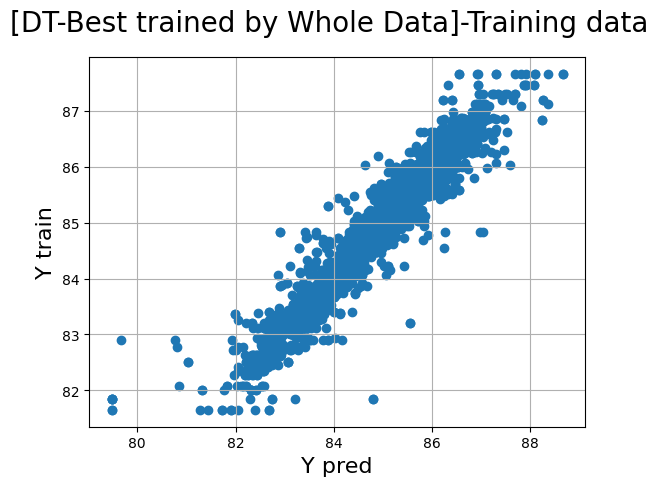

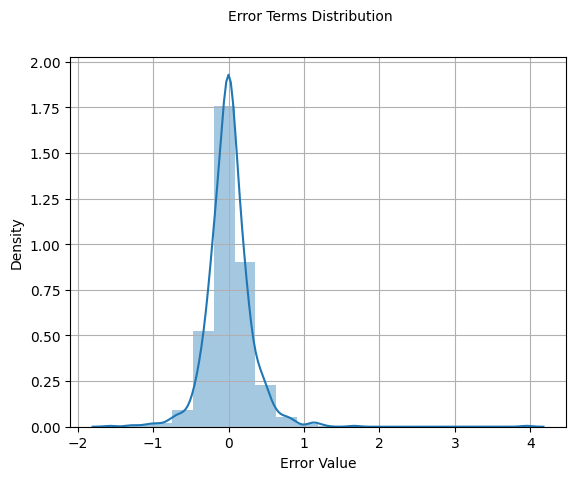

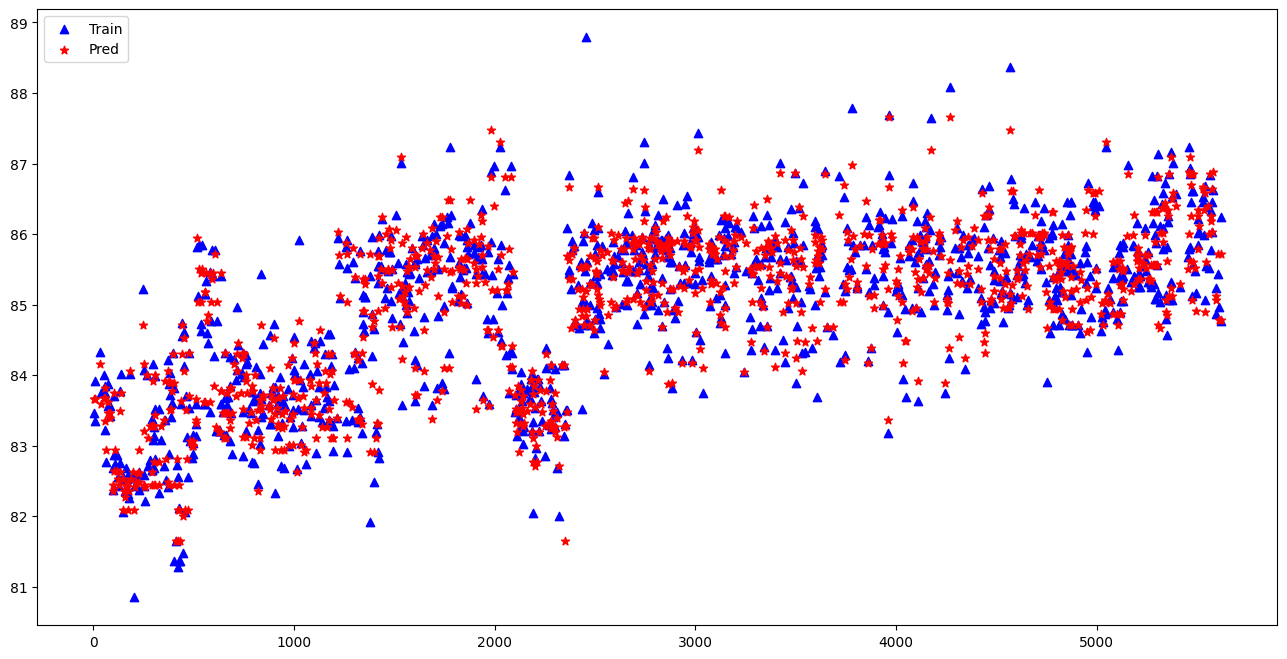

R2 Score Train: 0.9303215194064101
R2 Score Test: 0.9325950112540126


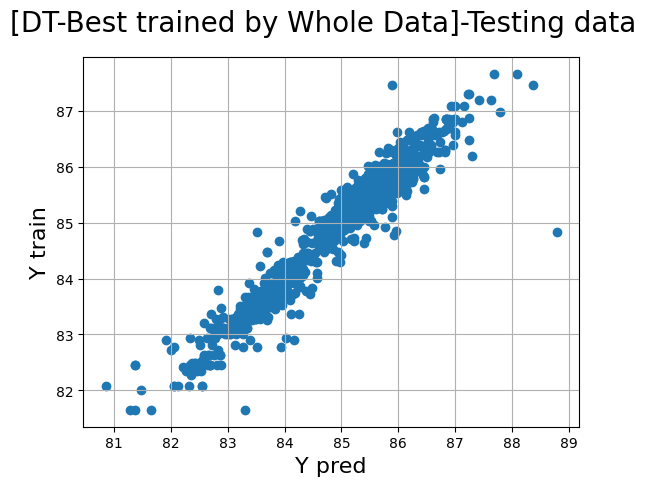

In [23]:
## Checking performance of [DT-Best trained by Whole Data] on Train Data
y_merged_train_dt, r2_train_dt_best_full=calculate_prediction_error(X_train_dt,y_train_dt,dt_best_full)
plots(y_train_dt, X_train_dt, dt_best_full,"[DT-Best trained by Whole Data]-Training data",'Y pred','Y train')

## Checking performance of [DT-Best trained by Whole Data] on Test Data
y_merged_test_dt, r2_test_dt_best_full=calculate_prediction_error(X_test_dt,y_test_dt,dt_best_full)
plots(y_test_dt, X_test_dt, dt_best_full,"[DT-Best trained by Whole Data]-Testing data",'Y pred','Y train')

print("R2 Score Train:", r2_train_dt_best_full)
print("R2 Score Test:", r2_test_dt_best_full)

## 5.2 Using Random Forest Regressor- With HyperParameter Tuning

In [24]:
%%time

# Create the Random Forest regressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameters to tune
params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform randomized search with cross-validation on train data
random_search_train = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=10, cv=10, scoring='r2', 
                                         random_state=42,verbose=0)
random_search_train.fit(X_train_rf, y_train_rf)

# Get the best estimator and its corresponding hyperparameters
rf_best_train = random_search_train.best_estimator_
best_params_train = random_search_train.best_params_

print("Best Hyperparameters (Train Data):", best_params_train)

# Perform randomized search with cross-validation on the whole dataset
random_search_full = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=10, cv=10, scoring='r2', 
                                        random_state=42,verbose=0)
random_search_full.fit(X, y)

# Get the best estimator and its corresponding hyperparameters
rf_best_full = random_search_full.best_estimator_
best_params_full = random_search_full.best_params_

print("Best Hyperparameters (Full Data):", best_params_full)

# Predict on train and test data using the best models
y_train_pred_train_rf = rf_best_train.predict(X_train_rf)
y_test_pred_train_rf = rf_best_train.predict(X_test_rf)
train_r2_train_rf = r2_score(y_train_rf, y_train_pred_train_rf)
test_r2_train_rf = r2_score(y_test_rf, y_test_pred_train_rf)
train_mae_train_rf = mean_absolute_error(y_train_rf, y_train_pred_train_rf)
test_mae_train_rf = mean_absolute_error(y_test_rf, y_test_pred_train_rf)
train_rmse_train_rf = np.sqrt(mean_squared_error(y_train_rf, y_train_pred_train_rf))
test_rmse_train_rf = np.sqrt(mean_squared_error(y_test_rf, y_test_pred_train_rf))

evaluation_metrics_rfBestModel_traindata = pd.DataFrame({'Method':'Random Forest Grid search-Train Data',
                                        'R2 Score (Train)': [train_r2_train_rf], 'R2 Score (Test)':[test_r2_train_rf],
                                       'MAE (Train)': [train_mae_train_rf], 'MAE (Test)':[test_mae_train_rf],
                                       'RMSE (Train)': [train_rmse_train_rf], 'RMSE (Test)':[test_rmse_train_rf]})

y_train_pred_full = rf_best_full.predict(X_train_rf)
y_test_pred_full = rf_best_full.predict(X_test_rf)
train_r2_full_rf = r2_score(y_train_rf, y_train_pred_full)
test_r2_full_rf = r2_score(y_test_rf, y_test_pred_full)
train_mae_full_rf = mean_absolute_error(y_train_rf, y_train_pred_full)
test_mae_full_rf = mean_absolute_error(y_test_rf, y_test_pred_full)
train_rmse_full_rf = np.sqrt(mean_squared_error(y_train_rf, y_train_pred_full))
test_rmse_full_rf = np.sqrt(mean_squared_error(y_test_rf, y_test_pred_full))
evaluation_metrics_rfBestModel_fulldata = pd.DataFrame({'Method':'Random Forest Grid search-Complete Data',
                                        'R2 Score (Train)': [train_r2_full_rf], 'R2 Score (Test)':[test_r2_full_rf],
                                       'MAE (Train)': [train_mae_full_rf], 'MAE (Test)':[test_mae_full_rf],
                                       'RMSE (Train)': [train_rmse_full_rf], 'RMSE (Test)':[test_rmse_full_rf]})

## Feature Importance of variables
imp_df_rf_train = pd.DataFrame({"VarName": X_train_rf.columns, "Importance": rf_best_train.feature_importances_})
imp_df_rf_train.sort_values(by="Importance", ascending=False, inplace=True)
print("Top 10 Variable Importance (Train Data - Hyperparameter Tuning on Train Data):")
print(imp_df_rf_train.head(10))

imp_df_rf_full = pd.DataFrame({"VarName": X_train_rf.columns, "Importance": rf_best_full.feature_importances_})
imp_df_rf_full.sort_values(by="Importance", ascending=False, inplace=True)
print("Top 10 Variable Importance (Train Data - Hyperparameter Tuning on Full Data):")
print(imp_df_rf_full.head(10))

Best Hyperparameters (Train Data): {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best Hyperparameters (Full Data): {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Top 10 Variable Importance (Train Data - Hyperparameter Tuning on Train Data):
                   VarName  Importance
1             Reactor WAIT    0.121352
5     Reactor 3 Inlet Temp    0.118141
28                    WABT    0.088204
3     Reactor 1 Inlet Temp    0.087030
6     Reactor 4 Inlet Temp    0.081535
4     Reactor 2 Inlet Temp    0.062049
10       Reactor 4 Delta T    0.039407
27                 50% IBP    0.038017
0   Feed N Plus 2A content    0.030658
15      Seperator Pressure    0.030391
Top 10 Variable Importance (Train Data - Hyperparameter Tuning on Full Data):
                   VarName  Importance
5     Reactor 3 Inlet Temp    0.120740
1             Reactor WAIT    0.118075
6   

In [25]:
evaluation_metrics_rfBestModel=pd.concat([evaluation_metrics_rfBestModel_traindata,evaluation_metrics_rfBestModel_fulldata],
                                         axis=0)
evaluation_metrics_rfBestModel

Method  R2 Score (Train)  R2 Score (Test)  \
0     Random Forest Grid search-Train Data          0.978375         0.912823   
0  Random Forest Grid search-Complete Data          0.979871         0.982222   

   MAE (Train)  MAE (Test)  RMSE (Train)  RMSE (Test)  
0     0.107914    0.230361      0.173957     0.346584  
0     0.103920    0.102974      0.167833     0.156513

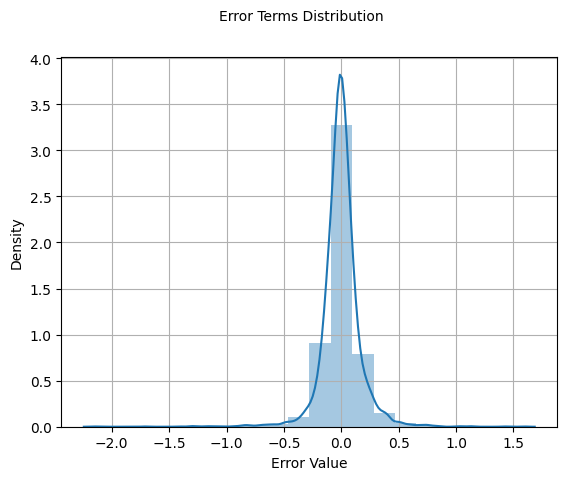

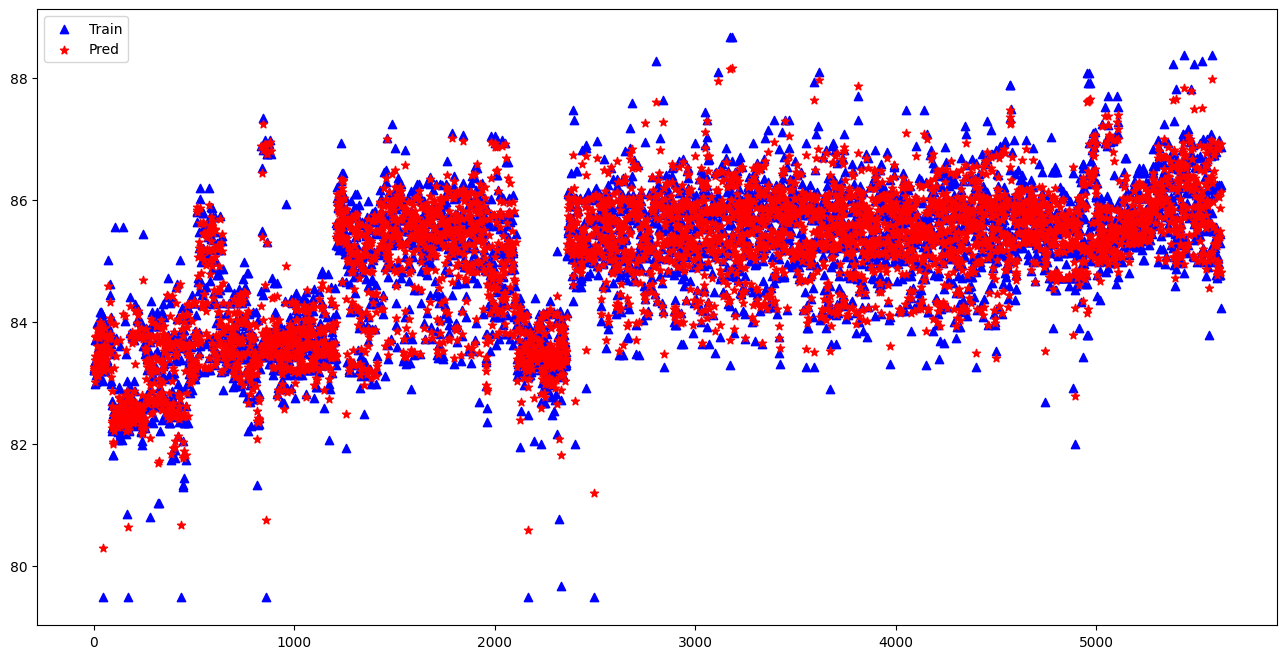

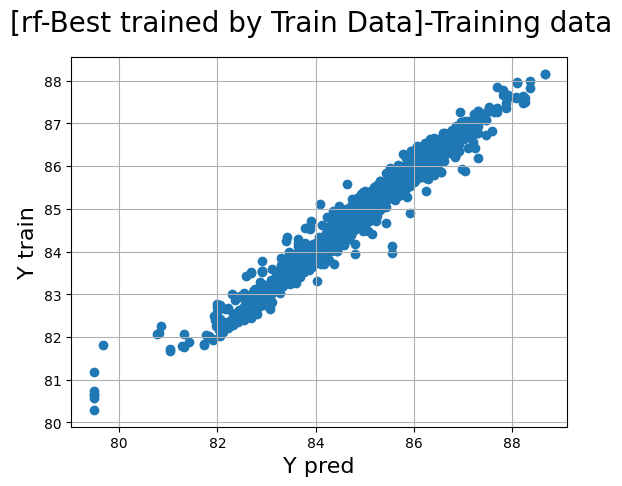

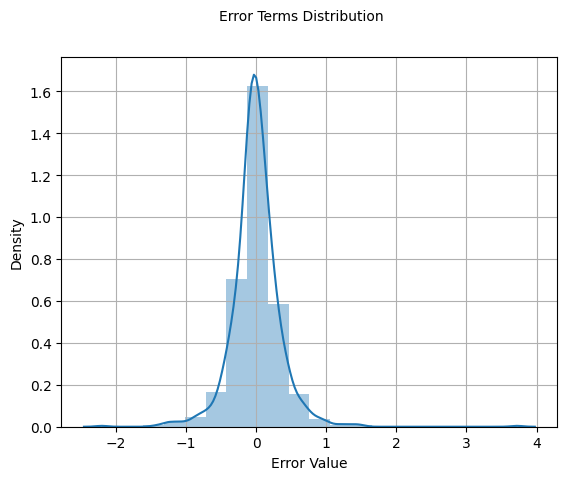

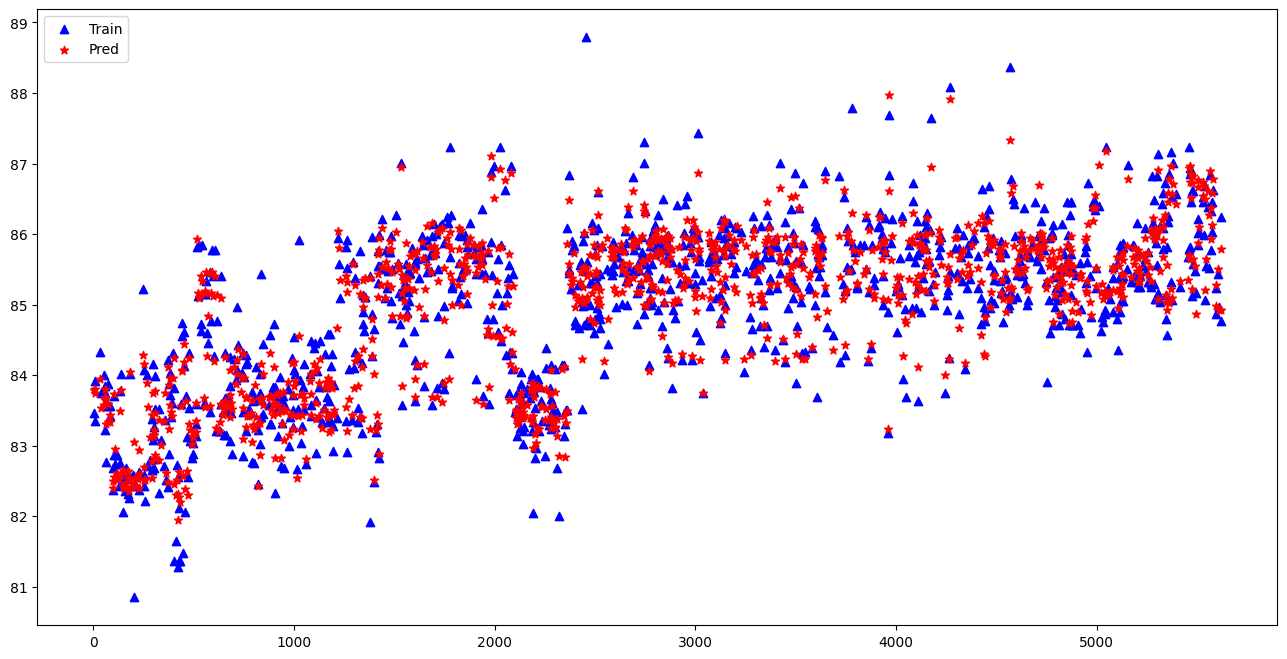

R2 Score Train: 0.9783750033758944
R2 Score Test: 0.9128225098856718


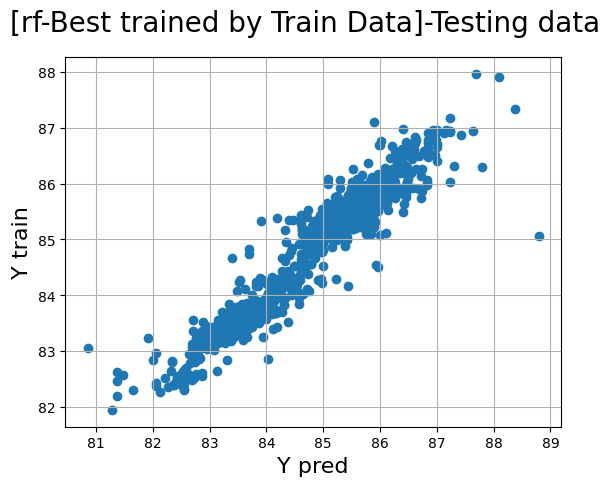

In [26]:
## Checking performance of [rf-Best trained by Train Data] on Train Data
y_merged_train_rf, r2_train_rf_best_train=calculate_prediction_error(X_train_rf,y_train_rf,rf_best_train)
plots(y_train_rf, X_train_rf, rf_best_train,"[rf-Best trained by Train Data]-Training data",'Y pred','Y train')

## Checking performance of [rf-Best trained by Train Data] on Test Data
y_merged_test_rf, r2_test_rf_best_train=calculate_prediction_error(X_test_rf,y_test_rf,rf_best_train)
plots(y_test_rf, X_test_rf, rf_best_train,"[rf-Best trained by Train Data]-Testing data",'Y pred','Y train')

print("R2 Score Train:", r2_train_rf_best_train)
print("R2 Score Test:", r2_test_rf_best_train)

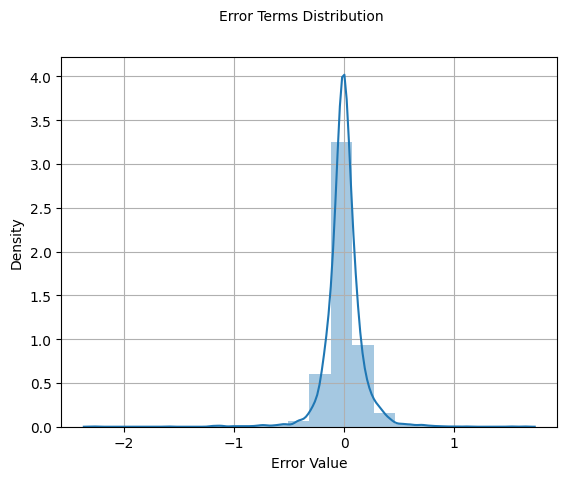

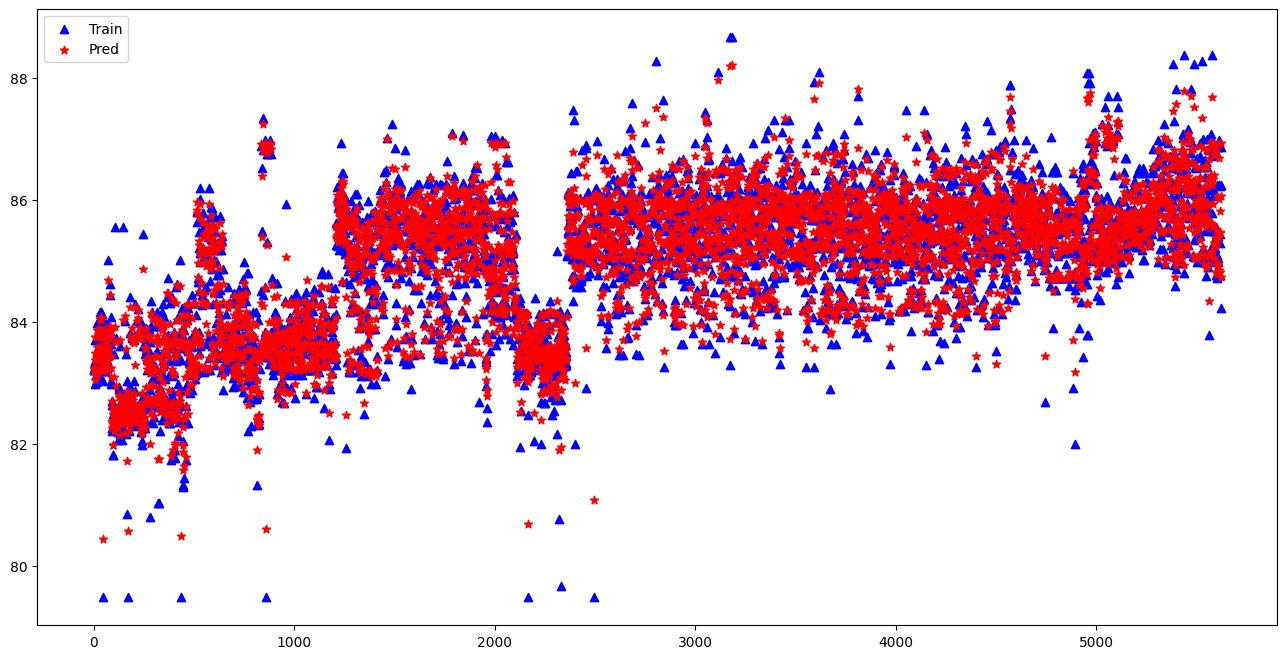

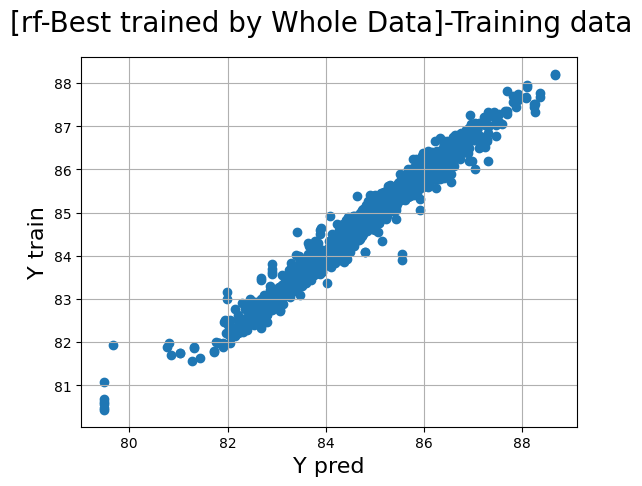

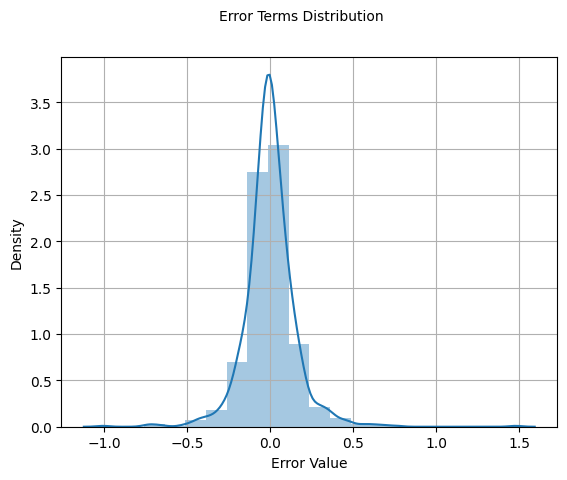

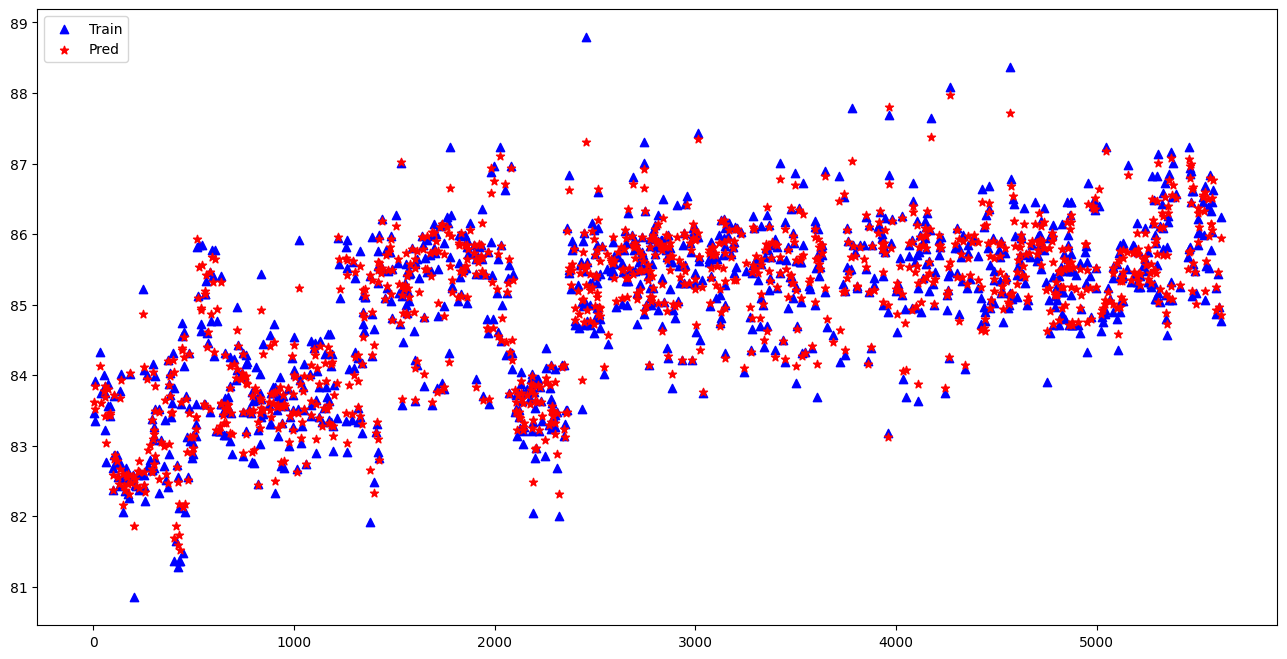

R2 Score Train: 0.9798706509732756
R2 Score Test: 0.9822216995332489


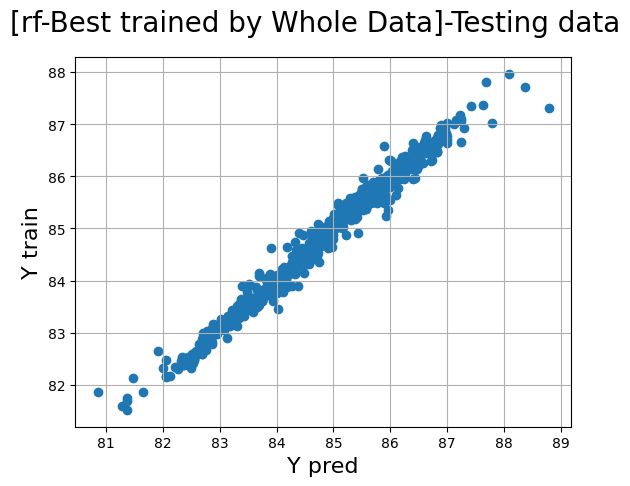

In [27]:
## Checking performance of [rf-Best trained by Whole Data] on Train Data
y_merged_train_rf, r2_train_rf_best_full=calculate_prediction_error(X_train_rf,y_train_rf,rf_best_full)
plots(y_train_rf, X_train_rf, rf_best_full,"[rf-Best trained by Whole Data]-Training data",'Y pred','Y train')

## Checking performance of [rf-Best trained by Whole Data] on Test Data
y_merged_test_rf, r2_test_rf_best_full=calculate_prediction_error(X_test_rf,y_test_rf,rf_best_full)
plots(y_test_rf, X_test_rf, rf_best_full,"[rf-Best trained by Whole Data]-Testing data",'Y pred','Y train')

print("R2 Score Train:", r2_train_rf_best_full)
print("R2 Score Test:", r2_test_rf_best_full)

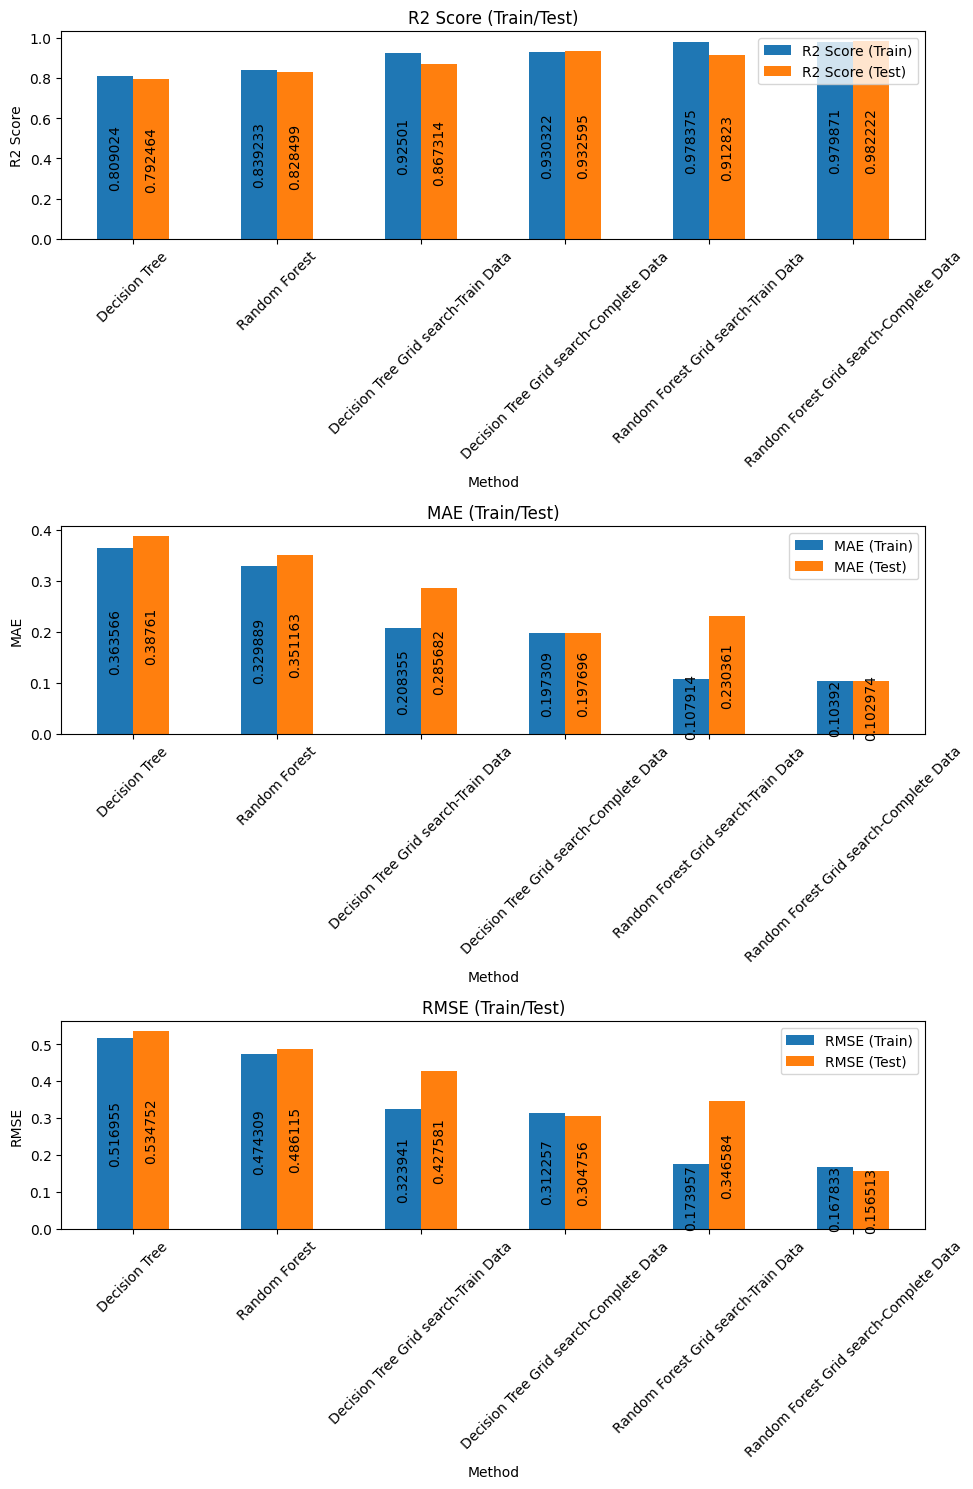

In [28]:
df_eval_dtrf=[evaluation_metrics_dt,evaluation_metrics_rf,
    evaluation_metrics_dtBestModel,evaluation_metrics_rfBestModel]
metrics = ['R2 Score', 'MAE', 'RMSE']
final_eval_metrics_dtrf=bar_plot_evalmetrics(df_eval_dtrf,metrics)

In [29]:
final_eval_metrics_dtrf

Method  R2 Score (Train)  R2 Score (Test)  \
0                            Decision Tree          0.809024         0.792464   
1                            Random Forest          0.839233         0.828499   
2     Decision Tree Grid search-Train Data          0.925010         0.867314   
3  Decision Tree Grid search-Complete Data          0.930322         0.932595   
4     Random Forest Grid search-Train Data          0.978375         0.912823   
5  Random Forest Grid search-Complete Data          0.979871         0.982222   

   MAE (Train)  MAE (Test)  RMSE (Train)  RMSE (Test)  
0     0.363566    0.387610      0.516955     0.534752  
1     0.329889    0.351163      0.474309     0.486115  
2     0.208355    0.285682      0.323941     0.427581  
3     0.197309    0.197696      0.312257     0.304756  
4     0.107914    0.230361      0.173957     0.346584  
5     0.103920    0.102974      0.167833     0.156513

In [31]:
#url_eval_metric='https://raw.githubusercontent.com/GaurangSeth/GaurangSethMScDataScience/master/Master_Eval_Metric.csv'
eval_script1=pd.read_csv('Master_Eval_Metric.csv')
eval_master=pd.concat([eval_script1,final_eval_metrics_dtrf],axis=0).reset_index(drop=True)
eval_master.to_csv('Master_Eval_Metric.csv',index=False)

PermissionError: [Errno 13] Permission denied: 'Master_Eval_Metric.csv'

In [ ]:
!pwd

In [ ]:
eval_master

## END